In [0]:
#Chargement de mon drive dans google colaboratory
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Copie du jeu de données dans colaboratory
cp /content/drive/My\ Drive/Database.zip /

In [0]:
import os
import zipfile
import pathlib
#Décompression du jeu de données
local_zip = '/Database.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/')
zip_ref.close()

In [0]:
import matplotlib.pyplot as plt
import csv
import pickle
import pandas as pd
import cv2
import imutils
%matplotlib inline

# Chemain d'accès au répertoire contenant les fichiers hog pour des images d'entraînement. Ici nous avons
# utilisé les fichiers du dossier HOG2
train_hog_path = '/Database/BaseDApprentissage/Training_HOG/HOG/HOG_02'

# Fonction pour récupérer les features des fichiers HOG et les enrégistrer dans un format csv. Cette fonction 
# va parcourir le chemain vers le dossier HOG2 et lire les fichier txt contenu dans chaque sous dossier
# du dossier HOG2. Le nom de Ces sous dossiers correspondent au nom de la classe (label). Notre fchier csv
# sera donc constitué de 1569 colonnes. les 1568 premières colonnes correspondent aux features HOG de
# chaque image (les fichiers txt contenus dans les sous dossiers) et la dernière colonne correspond au 
# label (nom de la classe). Cette fonction nous permettra d'avoir un bon format des données afin de l'utilisé
# sans problème avec la fonction random forest pour l'entreaînement du modèle

def read_hog(hog_path):
  # Parcourir le répertoire contenant les fichiers HOG des images
  for path, dirs, files in os.walk(hog_path):
    for file in files:
      # tableau pour stocker les features hog lus dans le fichier txt en cours
      features = []
      # Récupération du chemain absolu vers le fichier txt
      hog_file = os.path.join(path, file)
      # Récupération du nom du dossier parent (label de la classe) du fichier txt en cours
      classe_name = os.path.basename(os.path.dirname(hog_file))
      # Ouverture du fichier en lecture
      with open(hog_file, "r") as fic:
        # Lire chaque ligne du fichier et le stocker dans le tableau des feature du fichier
        features = fic.read().strip().split('\n')

      # Variable pour concatener les features du tableau et les séparer par des ; enfin de 
      # l'écrire dans le fichier csv sous le format correspondant
      image_feateares = ''
      for feat in features:
        image_feateares = image_feateares + feat + ';'
      image_feateares = image_feateares+classe_name+'\n'
      # Création du fichier csv et écriture des features de chaque fichier txt + le nom de la classe 
      # à l'intérieur.
      with open("features_data.csv", "a") as fichier:
        fichier.write(image_feateares)

In [0]:
# Appel de la fonction pour récupérer les features hog des images d'entraînement
read_hog(train_hog_path)

In [0]:
# lecture du fichier csv contenant les features hog des images d'entraînement dans un dataframe avec pandas
train_data = pd.read_csv('features_data.csv', header=None, sep=';')
# affichage de l'entête du dataframe
train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568
0,0.302419,0.123687,0.040699,0.046707,0.026919,0.073533,0.049432,0.207417,0.214256,0.122264,0.040131,0.135945,0.108818,0.064654,0.041825,0.136117,0.283180,0.172392,0.074284,0.082636,0.056377,0.322830,0.274144,0.079436,0.164389,0.234509,0.090610,0.097244,0.093733,0.189436,0.155142,0.128073,0.135043,0.116155,0.073783,0.142271,0.060463,0.022826,0.065279,0.048296,...,0.055162,0.071774,0.086230,0.360524,0.161891,0.068771,0.066888,0.064370,0.069788,0.074511,0.103704,0.281630,0.136211,0.046748,0.018799,0.041072,0.054302,0.175878,0.119149,0.232875,0.118998,0.240443,0.241199,0.060814,0.104969,0.142771,0.095704,0.343589,0.103172,0.055170,0.055370,0.075665,0.101063,0.295006,0.203970,0.200389,0.097266,0.073258,0.115335,4
1,0.015634,0.002282,0.054105,0.419593,0.158238,0.016237,0.004250,0.011575,0.025672,0.037528,0.209178,0.377198,0.096304,0.007237,0.013157,0.022498,0.129515,0.110722,0.055338,0.269032,0.116676,0.002260,0.046080,0.061940,0.110544,0.279738,0.271272,0.304249,0.069943,0.015119,0.030340,0.044593,0.035809,0.038361,0.121358,0.065861,0.010438,0.011180,0.008578,0.017850,...,0.138357,0.054238,0.011593,0.001706,0.000000,0.023667,0.033878,0.087191,0.291866,0.107653,0.009800,0.000000,0.002274,0.068149,0.064429,0.041837,0.056579,0.069351,0.009886,0.000000,0.003260,0.528114,0.482112,0.053959,0.146607,0.163015,0.022427,0.000938,0.000000,0.056204,0.037478,0.057223,0.119369,0.229273,0.042406,0.006741,0.006779,0.159288,0.186016,4
2,0.111578,0.050687,0.044901,0.110827,0.207893,0.083347,0.108556,0.130946,0.054983,0.025843,0.125708,0.146848,0.173763,0.036431,0.070050,0.064529,0.073474,0.003220,0.024696,0.084744,0.089320,0.154681,0.458437,0.295707,0.024775,0.062275,0.168665,0.088924,0.052540,0.165546,0.452238,0.127723,0.021535,0.028158,0.090003,0.110850,0.138577,0.074306,0.038494,0.023806,...,0.042960,0.013729,0.006680,0.013447,0.007233,0.128597,0.196203,0.361145,0.049158,0.001175,0.003354,0.003354,0.001153,0.021083,0.259608,0.433663,0.045741,0.001200,0.005093,0.005031,0.002413,0.003637,0.524733,0.249456,0.079158,0.003598,0.003459,0.006539,0.002167,0.048522,0.114877,0.325306,0.128992,0.016203,0.027041,0.014638,0.002221,0.009636,0.123712,4
3,0.239533,0.269306,0.035403,0.037159,0.067194,0.106822,0.064960,0.058261,0.087315,0.098207,0.015987,0.038485,0.097599,0.151904,0.393258,0.140571,0.204276,0.131717,0.093325,0.060112,0.069538,0.142016,0.109143,0.128548,0.134752,0.062149,0.005894,0.110109,0.155084,0.248348,0.381887,0.184605,0.024726,0.063992,0.063754,0.027133,0.057737,0.083845,0.244475,0.068165,...,0.323573,0.185017,0.035368,0.066094,0.033953,0.093251,0.136899,0.049792,0.165345,0.220969,0.167454,0.180887,0.029515,0.013657,0.004279,0.019760,0.041400,0.104258,0.259641,0.375436,0.146215,0.123616,0.033734,0.070306,0.102669,0.145579,0.165539,0.209979,0.101352,0.157086,0.106515,0.089605,0.252379,0.114313,0.229992,0.218692,0.148055,0.159460,0.059448,4
4,0.079663,0.137445,0.174798,0.063877,0.034333,0.013821,0.030365,0.028896,0.080577,0.152515,0.082588,0.071420,0.070541,0.073577,0.040353,0.037350,0.048254,0.222042,0.252956,0.260238,0.353447,0.058480,0.008268,0.008021,0.040300,0.277105,0.207843,0.217361,0.546481,0.138558,0.014686,0.015651,0.036731,0.070085,0.016543,0.015093,0.034019,0.028797,0.004855,0.009982,...,0.135203,0.030899,0.039003,0.062792,0.067867,0.050910,0.037714,0.568213,0.484343,0.087441,0.053345,0.174122,0.133258,0.027350,0.040922,0.176159,0.232212,0.063767,0.030037,0.119183,0.092872,0.067456,0.081541,0.214397,0.134102,0.105658,0.108736,0.128418,0.094161,0.052864,0.039640,0.082478,0.115413,0.126915,0.066278,0.165908,0.070180,0.017213,0.022377,4


In [0]:
# Fonction pour récupérer les features des fichiers HOG des images de test et les labels correspondant
# et les enrégistrer dans un format csv. 
# Cette fonction va parcourir le chemain vers le dossier HOG2 des images de test et lire les fichier txt contenus
# dans chaque dossier HOG2. Elle va lire aussi le fichier Test_VeriteTerrain(GT).csv de la base de test pour
# récupérer les noms des image et les labels correspondants.
# Notre fchier csv sera donc constitué de 1569 colonnes. 
# les 1568 colonnes correspondent aux features HOG des images test et la dernière colonne aux labels.

# Chemain d'accès au répertoire contenant les fichiers hog pour des images de test. Ici nous avons
# utilisé les fichiers du dossier HOG2
test_hog_path = '/Database/BaseDeTest/Test_HOG/HOG_02'
test_csv = '/Database/BaseDeTest/Test_VeriteTerrain(GT).csv'

def read_hog2(hog_path):
  '''Arguments: path to the traffic sign data
  Returns:   list of images, list of corresponding labels'''
  images = [] # images
  labels = [] # label correspondant
  prefix = hog_path + '/'
  gtFile = open(test_csv) # fichier d'anotation csv
  gtReader = csv.reader(gtFile, delimiter=';') # parser csv

  next(gtReader) # sauter l'entête
  # Parcourir toutes les images du fichier d'anotation csv
  for row in gtReader:
    # Récupérer le nom de l'image qui sera utilisé pour nom de fichier en ajoutant l'extension .txt
    file_name = row[0][:-4]
    # Lecture des features hog des images test contenues dans le dossier HOG2 de la base de test
    with open(prefix + file_name+ '.txt', "r") as fic:
      feateares = fic.read().strip().split('\n')
    # Création du fichier csv avec les features hog test lus précédemment + le label de l'image
    img_feateares=''
    for one_feateare in feateares:
      img_feateares=img_feateares+one_feateare+';'
    # Ajout du label correspondant à chaque image dans dernière colonne du fichier csv
    img_feateares=img_feateares+row[7]+'\n'
    with open('test_data.csv', 'a') as fichier:
      fichier.write(img_feateares)
  gtFile.close()


In [0]:
# Appel de la fonction pour récupérer les features hog des images de test
read_hog2(test_hog_path)

In [0]:
# lecture du fichier csv contenant les features hog des images de test dans un dataframe avec pandas
test_data = pd.read_csv('test_data.csv', header=None, sep=';')
# affichage de l'entête du dataframe
test_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568
0,0.077112,0.049983,0.143680,0.151308,0.038555,0.082894,0.166349,0.090185,0.104188,0.100738,0.215535,0.177288,0.055930,0.063975,0.099278,0.140718,0.171471,0.095544,0.120509,0.089032,0.036453,0.142469,0.134749,0.060350,0.377701,0.265219,0.163308,0.141554,0.073729,0.074374,0.126787,0.103715,0.012444,0.019049,0.027556,0.022371,0.007593,0.003344,0.002644,0.012993,...,0.008126,0.006722,0.007335,0.091184,0.063797,0.015779,0.001250,0.039124,0.086540,0.075368,0.019438,0.473649,0.637056,0.015327,0.012919,0.106883,0.143415,0.087703,0.025112,0.024885,0.038218,0.010486,0.024725,0.047442,0.106276,0.083919,0.047099,0.069653,0.105911,0.030990,0.009593,0.095782,0.164022,0.101219,0.056227,0.084591,0.029830,0.006890,0.018699,16
1,0.119052,0.003266,0.006143,0.247642,0.188298,0.013261,0.002400,0.108383,0.101999,0.017423,0.004926,0.266080,0.295208,0.013048,0.001328,0.153389,0.315290,0.023825,0.031323,0.182069,0.206065,0.010951,0.001659,0.334060,0.274764,0.048709,0.029293,0.129379,0.185493,0.116980,0.092102,0.378674,0.030642,0.017596,0.008270,0.133062,0.142838,0.001929,0.001568,0.045484,...,0.127043,0.037253,0.057937,0.097563,0.026142,0.007395,0.014669,0.395792,0.390840,0.049571,0.127127,0.142368,0.036735,0.011474,0.079633,0.178549,0.028302,0.073083,0.214105,0.096671,0.023134,0.032192,0.427316,0.047514,0.076725,0.060989,0.167363,0.246273,0.067284,0.031518,0.025786,0.002323,0.026539,0.213288,0.317063,0.171908,0.053293,0.022978,0.010473,1
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.309462,0.351681,0.000060,0.010713,0.148502,0.104254,0.000000,0.000000,0.208257,0.217466,0.001007,0.000000,0.000000,0.000000,0.000000,0.000000,0.393222,0.447801,0.000000,0.006520,0.130205,0.177812,0.010616,0.022378,0.261561,0.278857,0.001151,0.004384,0.069356,0.060222,0.000000,0.000000,0.127693,0.179755,0.001161,...,0.452165,0.447671,0.033033,0.023920,0.003452,0.000924,0.004349,0.018030,0.385495,0.312827,0.000000,0.000529,0.005570,0.008301,0.006485,0.021533,0.157817,0.107365,0.000000,0.013324,0.134879,0.064517,0.048551,0.002916,0.430287,0.472690,0.000000,0.000000,0.024807,0.012307,0.000395,0.000000,0.208758,0.179007,0.000000,0.042548,0.374231,0.062075,0.001808,38
3,0.026402,0.036410,0.091313,0.107078,0.079168,0.111932,0.039147,0.007433,0.013309,0.009527,0.015879,0.080135,0.295904,0.388529,0.182774,0.070541,0.002436,0.003864,0.142704,0.374793,0.298518,0.097773,0.009539,0.000000,0.002447,0.001580,0.013639,0.375906,0.408877,0.203929,0.106511,0.110688,0.001214,0.000088,0.004111,0.062549,0.253033,0.245725,0.326384,0.126469,...,0.055659,0.358907,0.129007,0.031768,0.097295,0.092958,0.141710,0.100115,0.028620,0.058216,0.096667,0.100782,0.203848,0.138290,0.172493,0.236578,0.049182,0.052278,0.102717,0.179673,0.180185,0.098016,0.322441,0.111612,0.068713,0.170322,0.070401,0.027510,0.046111,0.089039,0.199487,0.152112,0.166327,0.176707,0.011758,0.122038,0.548236,0.144410,0.222143,33
4,0.042312,0.139276,0.093038,0.039349,0.156275,0.304959,0.044027,0.028507,0.119267,0.188071,0.210651,0.100037,0.233653,0.214910,0.048232,0.048967,0.040066,0.103603,0.094565,0.185819,0.251838,0.203746,0.092921,0.043589,0.067133,0.133992,0.182767,0.194022,0.281615,0.329073,0.073014,0.047348,0.077590,0.085849,0.133501,0.119353,0.183468,0.094354,0.038752,0.026333,...,0.018236,0.153695,0.251007,0.055598,0.035857,0.148731,0.430347,0.066502,0.136286,0.167263,0.223180,0.046610,0.197649,0.136416,0.073898,0.016792,0.327745,0.350210,0.064759,0.044657,0.210486,0.139218,0.000000,0.139371,0.108506,0.138796,0.287241,0.080108,0.081362,0.097460,0.274602,0.149952,0.372411,0.133690,0.149661,0.089199,0.088972,0.045503,0.046976,11


In [0]:
from sklearn.ensemble import RandomForestClassifier
# Récupération des features HOG de toutes les images d'entraînement sans la colonne de label
classe_features = train_data.iloc[:,:-1].values

In [0]:
# Récupération des label des images d'entraînement
train_label = train_data.iloc[:,-1].values

In [0]:
# Récupération des features des images test
test_image_feature = test_data.iloc[:,:-1].values

In [0]:
# Récupération des labels des images test
test_labels = test_data.iloc[:,-1].values

In [0]:
# Importation des librairy nacessaire pour le random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report
from sklearn.externals import joblib

# Division des données en donnée d'apprentissage et de validation. Ici nous allons prendre 10 % pour les données de validation
# et 90% pour l'apprentissage
(trainData, valData, trainLabels, valLabels) = train_test_split(classe_features, train_label,
    test_size=0.1, random_state=84)
 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
# Affichage de la taille des données obtenues après le split
print("training data : {}".format(len(trainLabels)))
print("validation data : {}".format(len(valLabels)))
print("testing data : {}".format(len(test_labels)))

training data : 35288
validation data : 3921
testing data : 12630


In [0]:
# Création du modèle random forest avec la méthode RandomForestClassifier de sklearn avec les paramètres par défaut
rf = RandomForestClassifier()

In [0]:
# Appel de la méthode fit() avec en argument les donnée et les labels d'entainement obtenues après le split.
# Cette fonction va permettre de lancer l'apprentissage du modèle
rf.fit(trainData,trainLabels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:

# Enrégistrement du modèle formé avec pickle pour une utilisation ultérieur.
joblib.dump(rf, 'clf_rf_hog.pkl') 
print("[INFO] Classifier Saved")

[INFO] Classifier Saved


In [0]:
# Affichage de la précision du modèle sur les données d'entraînement
print("accuracy on training data: {}".format(rf.score(trainData,trainLabels)))

accuracy on training data: 1.0


In [0]:
# Affichage de la précision du modèle sur les données de test
print("accuracy on test data: {}".format(rf.score(test_image_feature,test_labels)))

accuracy on test data: 0.9596991290577989


In [0]:
# Affichage de la précision du modèle sur les données de validation
print("accuracy on validation data: {}".format(rf.score(valData,valLabels)))

accuracy on validation data: 0.9885233358837031


In [0]:
# Calcul des prédictions du modèle sur les données de test
predictions = rf.predict(test_image_feature)
 
# Rapport de classification final démontrant l'exactitude du classificateur sur les données de test
print("EVALUATION ON TESTING DATA")
print(classification_report(test_labels, predictions))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        60
           1       0.98      0.97      0.97       720
           2       0.91      0.99      0.95       750
           3       0.96      0.90      0.93       450
           4       0.97      0.98      0.98       660
           5       0.89      0.93      0.91       630
           6       0.99      0.83      0.90       150
           7       0.97      0.95      0.96       450
           8       0.93      0.91      0.92       450
           9       0.95      1.00      0.97       480
          10       0.98      1.00      0.99       660
          11       0.92      0.97      0.95       420
          12       0.98      0.98      0.98       690
          13       0.99      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.94      0.98      0.96       210
          16       1.00      0.99      0.99       150


In [0]:
# Calcul de la matrice de confusion avec scklearn
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(test_labels, predictions)

print(CM)


[[ 49   2   0 ...   0   0   0]
 [  0 699  10 ...   0   0   0]
 [  0   3 744 ...   0   0   0]
 ...
 [  0   1   1 ...  77   0   0]
 [  0   0   0 ...   0  42   0]
 [  0   0   0 ...   1   1  86]]


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Fonction d'aide pour afficher la matrice de confusion
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig


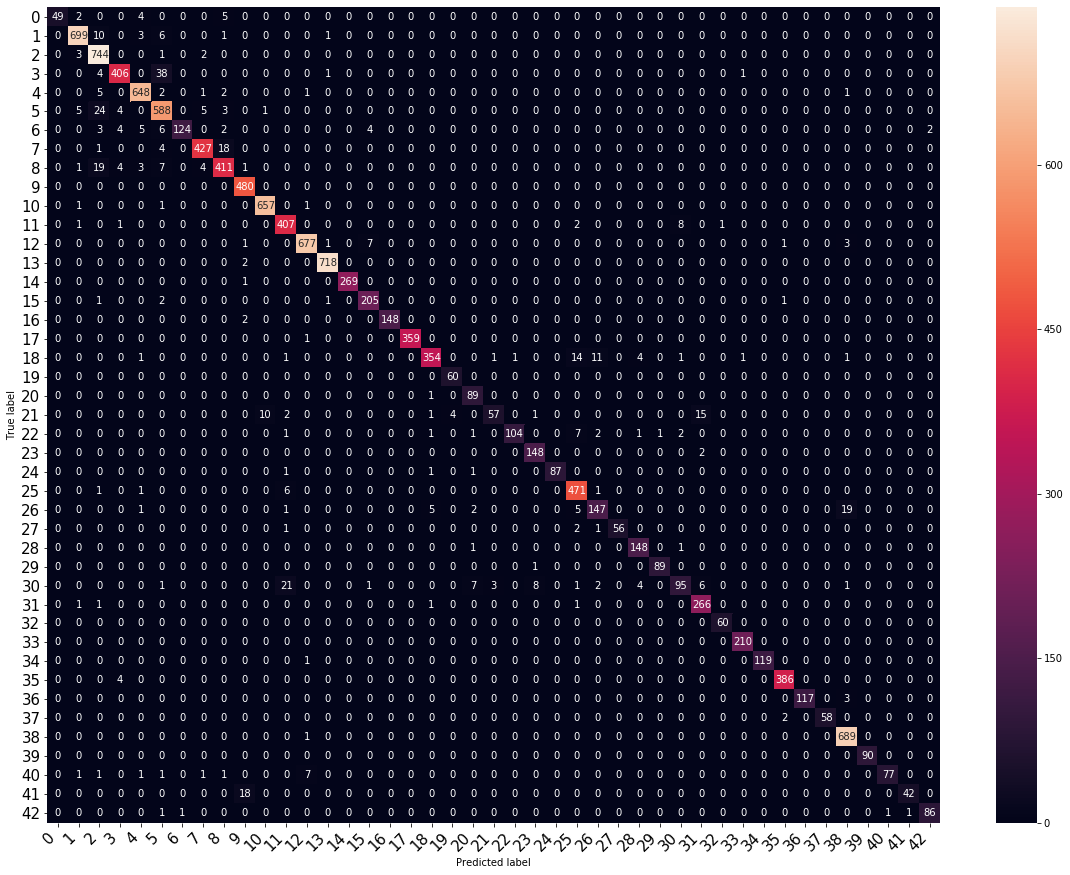

In [0]:
# appel de la fonction pour afficher la matrice de confusion
import numpy as np

class_names = np.unique(train_label)
fig = print_confusion_matrix(CM, class_names, figsize = (20,15), fontsize=15)

fig.show()

In [0]:
from sklearn.svm import SVC,LinearSVC

# Création du modèle SVM avec les paramètres par défaut. Ici on utilise le noyau linéair
svc = LinearSVC()
# Entraînement du modèle sur les données 
svc.fit(trainData,trainLabels)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [0]:
# Calcul du score de cross validation sur les données de test et sauvegarde du modèle
scores = cross_val_score(svc,test_image_feature,test_labels)
print(scores)
print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
joblib.dump(svc, 'clf_svc_hog.pkl') 
print("[INFO] Classifier Saved")

[0.99010293 0.99287411 0.99287411 0.99168646 0.99247823]
[INFO] Succefully trained the classsifier. 
 Saving the classifier for further use
[INFO] Classifier Saved


In [0]:
# Affichage de la précision du modèle sur les données d'apprentissage
print("accuracy on training data: {}".format(svc.score(trainData,trainLabels)))


accuracy on training data: 0.9999716617547042


In [0]:
# Affichage de la précision du modèle sur les données de test
print("accuracy on test data: {}".format(svc.score(test_image_feature,test_labels)))


accuracy on test data: 0.9578780680918448


In [0]:
# Affichage de la précision du modèle sur les données de validation
print("accuracy on validation data: {}".format(svc.score(valData,valLabels)))


accuracy on validation data: 0.9926039275694976


In [0]:
# Calcul des prédictions du modèle sur les données de test
predictions_svm = svc.predict(test_image_feature)
 
# Rapport de classification final démontrant l'exactitude du classificateur sur les données de test
print("EVALUATION ON TESTING DATA")
print(classification_report(test_labels, predictions_svm))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        60
           1       0.97      0.96      0.96       720
           2       0.94      0.98      0.96       750
           3       0.93      0.94      0.93       450
           4       0.97      0.98      0.97       660
           5       0.93      0.90      0.92       630
           6       0.97      0.83      0.89       150
           7       0.94      0.92      0.93       450
           8       0.92      0.96      0.94       450
           9       0.96      1.00      0.98       480
          10       0.99      0.99      0.99       660
          11       0.96      0.93      0.94       420
          12       0.99      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       0.99      0.98      0.98       270
          15       0.97      1.00      0.98       210
          16       1.00      0.99      1.00       150


In [0]:
# Visualise classical Confusion M0atrix
from sklearn.metrics import confusion_matrix
CM2 = confusion_matrix(test_labels, predictions_svm)



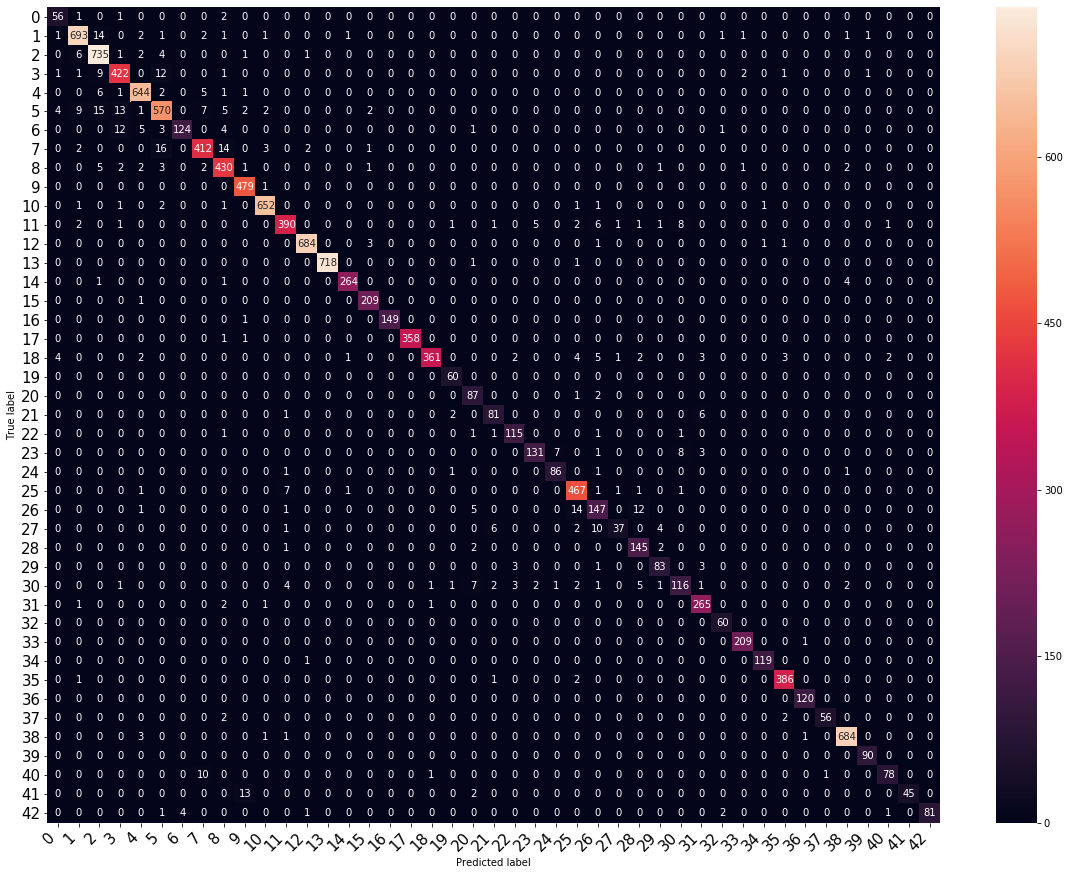

In [0]:
# appel de la fonction pour afficher la matrice de confusion
fig = print_confusion_matrix(CM2, class_names, figsize = (20,15), fontsize=15)

fig.show()

In [0]:
from sklearn.svm import NuSVC
X = np.array(trainData)
y = np.array(trainLabels)
# Création du modèle SVM non lineaire avec les paramètres par défaut(Noyau RBF avec valeur de Gamma par defaut)
svcRBF = NuSVC(kernel='rbf',nu=0.01)
# Entraînement du modèle sur les données
svcRBF.fit(X,y)

NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.01, probability=False, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

In [0]:
# Affichage de la précision du modèle svm non linéair sur les données d'apprentissage
print("accuracy on training data: {}".format(svcRBF.score(trainData,trainLabels)))

# Affichage de la précision du modèle svm non linéair sur les données de test
print("accuracy on test data: {}".format(svcRBF.score(test_image_feature,test_labels)))

# Affichage de la précision du modèle svm non linéair sur les données de validation
print("accuracy on validation data: {}".format(svcRBF.score(valData,valLabels)))

accuracy on training data: 1.0
accuracy on test data: 0.9518606492478227
accuracy on validation data: 0.9989798520785514
